<h1 style="text-align:center;">Valorant Pro Match Analysis</h1>


In [2]:
import numpy as np
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss, mean_squared_error, mean_absolute_error, r2_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler

import datetime

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def val_df_gen(db_name):
    """
    Dataset:
    https://www.kaggle.com/visualize25/valorant-pro-matches-full-data

    """

    val_sql = sql.connect('/content/drive/MyDrive/Valorant/valorant.sqlite')

    scoreboard_df = pd.read_sql("""
    SELECT
        *
    FROM
        Game_Scoreboard
    """, val_sql)
    rounds_df = pd.read_sql("""
        SELECT
            *
        FROM
            Game_Rounds
    """, val_sql)
    games_df = pd.read_sql("""
        SELECT
            *
        FROM
            Games
    """, val_sql)
    matches_df = pd.read_sql("""
        SELECT
            *
        FROM
            Matches
    """, val_sql)

    val_sql.close()

    merge_df = matches_df.merge(games_df)
    merge_df = merge_df.merge(rounds_df)
    merge_df = merge_df.merge(scoreboard_df)
    merge_df['MatchID'] = merge_df['MatchID'].astype(int)

    scoreboard_df = scoreboard_df.dropna()
    rounds_df = rounds_df.dropna()
    games_df = games_df.dropna()
    matches_df = matches_df.dropna()
    merge_df = merge_df.dropna()

    scoreboard_df.to_csv('sb_df.csv')
    rounds_df.to_csv('r_df.csv')
    games_df.to_csv('g_df.csv')
    matches_df.to_csv('ma_df.csv')
    merge_df.to_csv('me_df.csv')

    return scoreboard_df, rounds_df, games_df, matches_df, merge_df

In [5]:
def df_creator():
    """
    Attempts to read .csv files for the dataframes. If there are none,
    attempts to generate them by reading them in from the sql db file.
    """
    try:
        print('Reading .csv files')
        sb_df = pd.read_csv('sb_df.csv')
        r_df = pd.read_csv('r_df.csv')
        g_df = pd.read_csv('g_df.csv')
        ma_df = pd.read_csv('ma_df.csv')
        me_df = pd.read_csv('me_df.csv')
    except IOError:
        print('.csv files not found. Creating .csv files')
        sb_df, r_df, g_df, ma_df, me_df = val_df_gen('valorant.sqlite')

    return sb_df, r_df, g_df, ma_df,

In [6]:
%%capture
df_creator()

In [7]:
scoreboard_df = pd.read_csv('sb_df.csv')
rounds_df = pd.read_csv('r_df.csv')
games_df = pd.read_csv('g_df.csv')
matches_df = pd.read_csv('ma_df.csv')
merge_df = pd.read_csv('me_df.csv')

In [8]:
scoreboard_df_prep = scoreboard_df.drop(['Unnamed: 0', 'PlayerID', 'TeamAbbreviation', 'PlusMinus', 'FirstKills', 'FirstDeaths',
       'FKFD_PlusMinus', 'Num_2Ks', 'Num_3Ks', 'Num_4Ks', 'Num_5Ks', 'OnevOne',
       'OnevTwo', 'OnevThree', 'OnevFour', 'OnevFive', 'Econ', 'Plants',
       'Defuses'], axis=1)

print(scoreboard_df_prep.columns)

scoreboard_df_prep = pd.get_dummies(scoreboard_df_prep, columns=['PlayerName']) #One hot encoding
scoreboard_df_prep.head(10)

Index(['GameID', 'PlayerName', 'Agent', 'ACS', 'Kills', 'Deaths', 'Assists',
       'KAST_Percent', 'ADR', 'HS_Percent'],
      dtype='object')


,GameID,Agent,ACS,Kills,Deaths,Assists,KAST_Percent,ADR,HS_Percent,PlayerName_1TaPGoD,...,PlayerName_zeeq,PlayerName_zekken,PlayerName_zeldris,PlayerName_zhan,PlayerName_zill,PlayerName_zizox,PlayerName_zombs,PlayerName_zyad,PlayerName_zyf,PlayerName_Λero
0,60894,jett,313.0,24.0,10.0,3.0,0.65,195.0,0.31,0,...,0,0,0,0,0,0,0,0,0,0
1,60894,chamber,227.0,16.0,10.0,7.0,0.90,161.0,0.16,0,...,0,0,0,0,0,0,0,0,0,0
2,60894,sova,226.0,17.0,9.0,8.0,0.85,148.0,0.27,0,...,0,0,0,0,0,0,0,0,0,0
3,60894,viper,218.0,17.0,12.0,2.0,0.70,141.0,0.19,0,...,0,0,0,0,0,0,0,0,0,0
4,60894,skye,80.0,5.0,13.0,3.0,0.70,55.0,0.22,0,...,0,0,0,0,0,0,0,0,0,0
5,60894,astra,229.0,15.0,16.0,5.0,0.55,155.0,0.31,0,...,0,0,0,0,0,0,0,0,0,0
6,60894,sova,203.0,12.0,14.0,6.0,0.65,151.0,0.22,0,...,0,0,0,0,0,0,0,0,0,0
7,60894,chamber,173.0,12.0,16.0,2.0,0.70,103.0,0.18,0,...,0,0,0,0,0,0,0,0,0,0
8,60894,skye,125.0,9.0,15.0,1.0,0.50,94.0,0.36,0,...,0,0,0,0,0,0,0,0,0,0
9,60894,viper,89.0,6.0,18.0,3.0,0.45,57.0,0.22,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
name = "yay"
column = "ADR"

# Create a boolean mask that selects rows where 'PlayerName' == name
mask = merge_df['PlayerName'] == name

# Use the boolean mask to select the rows where 'PlayerName' == name and the desired column
data = merge_df.loc[mask, [column]]

# Check if any data was found
if not data.empty:
    print("The {} for player {} is:".format(column, name))
    display(data)
else:
    print("No data found for player {} in column {}.".format(name, column))

The ADR for player yay is:


,ADR
2421,95.0
2427,178.0
2437,187.0
2512,146.0
2522,208.0
2637,165.0
2647,140.0


# Prediction of Winning Team

<h2>Pre-processing Data</h2>

<ipython-input-25-a9ac86d3a66b>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  merge_df.groupby('Agent')['ACS', 'Kills', 'Assists', 'Deaths'].mean()


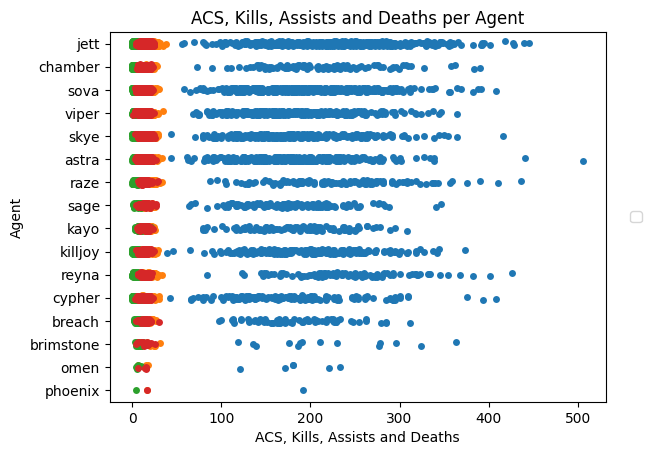

In [25]:
# ACS per agent numerical value (RQ1)

merge_df.groupby('Agent')['ACS', 'Kills', 'Assists', 'Deaths'].mean()

# graph for ACS per agent (RQ1)
sns.stripplot(data=merge_df, x="ACS", y="Agent")
sns.stripplot(data=merge_df, x="Kills", y="Agent")
sns.stripplot(data=merge_df, x="Assists", y="Agent")
sns.stripplot(data=merge_df, x="Deaths", y="Agent" )

plt.title("ACS, Kills, Assists and Deaths per Agent")
plt.xlabel("ACS, Kills, Assists and Deaths")
plt.ylabel("Agent")
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0)

<ipython-input-30-0f88ff563ae7>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  merge_df.groupby('Map')['ACS', 'Kills', 'Assists', 'Deaths'].mean()


Text(50.77770833333334, 0.5, 'Map')

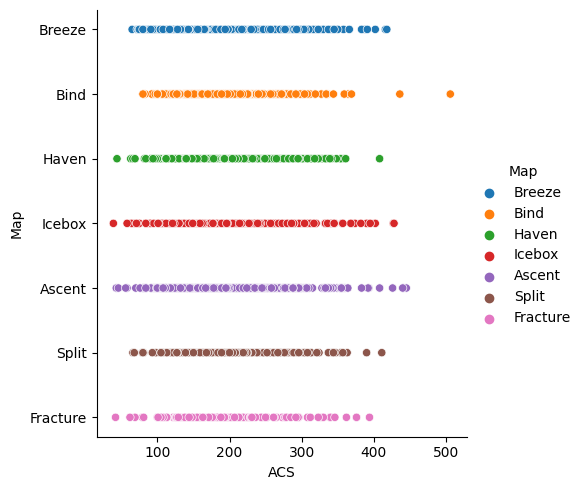

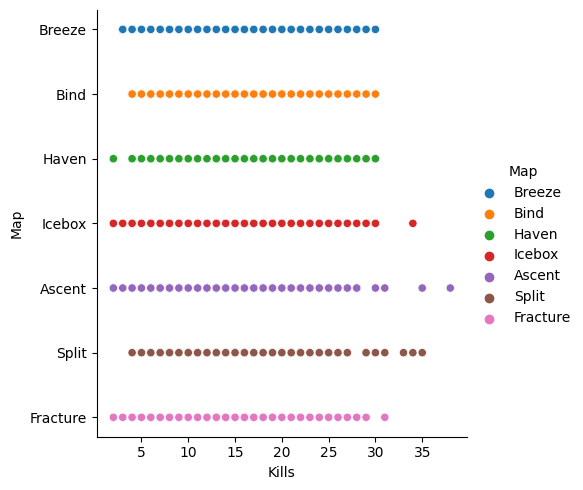

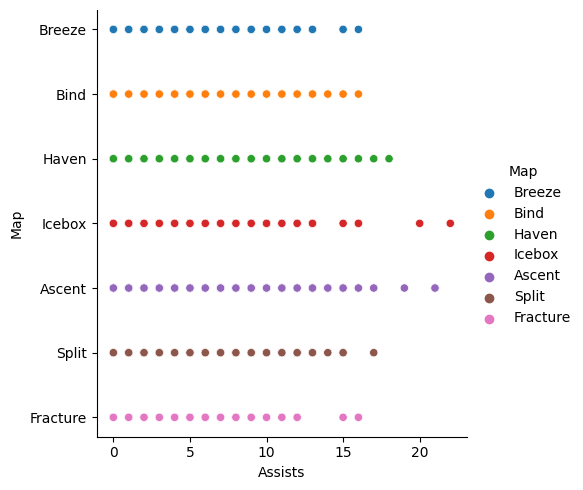

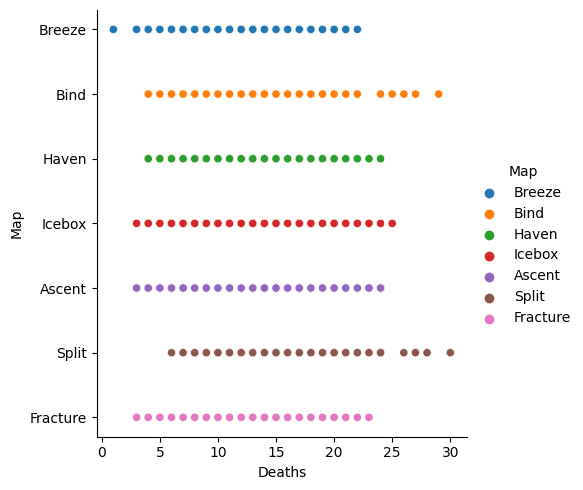

In [30]:
# ACS per map numerical value (RQ1)
merge_df.groupby('Map')['ACS', 'Kills', 'Assists', 'Deaths'].mean()

# graph for ACS per map (RQ1)
sns.relplot(data=merge_df, x="ACS", y="Map", hue="Map")
sns.relplot(data=merge_df, x="Kills", y="Map", hue="Map")
sns.relplot(data=merge_df, x="Assists", y="Map", hue="Map")
sns.relplot(data=merge_df, x="Deaths", y="Map", hue="Map")

# plt.title("ACS, Kills, Assists and Deaths per Map")
plt.xlabel("ACS")
plt.xlabel("Kills")
plt.xlabel("Assists")
plt.xlabel("Deaths")
plt.ylabel("Map")

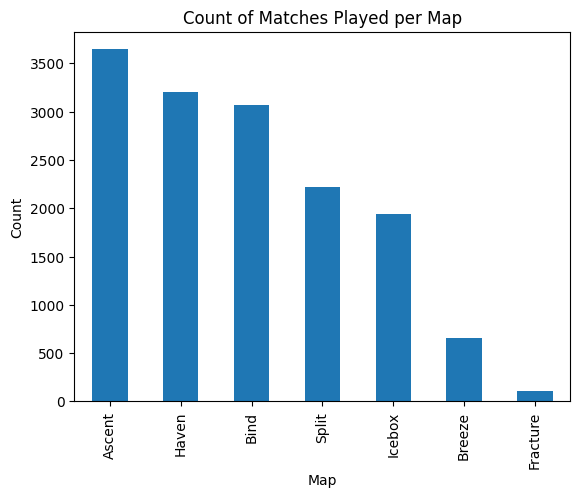

In [31]:
# Count the number of matches played on each map
map_counts = games_df['Map'].value_counts()

# Create a bar chart of the map counts
map_counts.plot.bar()

# Set the title and axis labels
plt.title('Count of Matches Played per Map')
plt.xlabel('Map')
plt.ylabel('Count')

# Show the plot
plt.show()

# Prediction from Scoreboard

<h2>Pre-processing Data</h2>

In [ ]:
player_data = scoreboard_df[['PlayerName', 'ACS', 'Agent', 'ADR',
                'Econ', 'TeamAbbreviation',
                'Kills', 'Deaths', 'Assists']]

#player_data.head()
print(player_data)

       PlayerName    ACS    Agent    ADR  Econ TeamAbbreviation  Kills  \
0          Reduxx  313.0     jett  195.0  74.0             Boos   24.0   
1          ChurmZ  227.0  chamber  161.0  67.0             Boos   16.0   
2        diaamond  226.0     sova  148.0  58.0             Boos   17.0   
3          Boltzy  218.0    viper  141.0  48.0             Boos   17.0   
4          Virtyy   80.0     skye   55.0  21.0             Boos    5.0   
...           ...    ...      ...    ...   ...              ...    ...   
3362        Shawn  196.0     sage  110.0  43.0              GEN   12.0   
3363       NaturE  149.0     jett  101.0  39.0              GEN   10.0   
3364  Temperature  123.0     sova   92.0  44.0              GEN    7.0   
3365          gMd  121.0     omen   87.0  32.0              GEN    6.0   
3366       koosta  101.0    viper   70.0  35.0              GEN    5.0   

      Deaths  Assists  
0       10.0      3.0  
1       10.0      7.0  
2        9.0      8.0  
3       12.0   

In [ ]:
player_data.isnull().sum()

PlayerName           0
ACS                  0
Agent                0
ADR                  0
Econ                 0
TeamAbbreviation    43
Kills                0
Deaths               0
Assists              0
dtype: int64

In [ ]:
player_data = player_data.dropna()

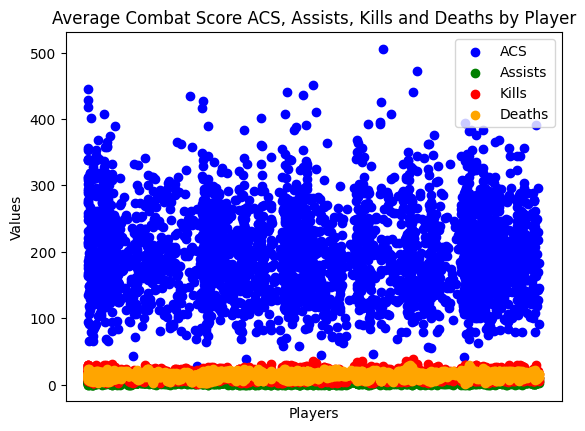

In [ ]:
plt.scatter(player_data['PlayerName'], player_data['ACS'], color='blue', label='ACS')
plt.scatter(player_data['PlayerName'], player_data['Assists'], color='green', label='Assists')
plt.scatter(player_data['PlayerName'], player_data['Kills'], color='red', label='Kills')
plt.scatter(player_data['PlayerName'], player_data['Deaths'], color='orange', label='Deaths')


plt.title('Average Combat Score ACS, Assists, Kills and Deaths by Player')
plt.xlabel('Players')
plt.ylabel('Values')

plt.legend()
plt.xticks([], [])
plt.rcParams['figure.figsize'] = [16, 9]


# Show the plot
plt.show()

In [ ]:
# Preprocess the data
# one hot encode categorical features
player_data = pd.get_dummies(player_data, columns=['Agent', 'TeamAbbreviation'])

# Scale the numerical features using StandardScaler
scaler = MinMaxScaler()
numerical_cols = ['ACS', 'Econ', 'ADR', 'Kills', 'Deaths', 'Assists']
player_data[numerical_cols] = scaler.fit_transform(player_data[numerical_cols])

player_data.head()

,PlayerName,ACS,ADR,Econ,Kills,Deaths,Assists,Agent_astra,Agent_breach,Agent_brimstone,...,TeamAbbreviation_XSET,TeamAbbreviation_YFP,TeamAbbreviation_ZMM.B,TeamAbbreviation_Zeni,TeamAbbreviation_cism,TeamAbbreviation_ex-FB,TeamAbbreviation_ex-L,TeamAbbreviation_ex-S,TeamAbbreviation_same,TeamAbbreviation_waff
0,Reduxx,0.596234,0.637363,0.356383,0.621622,0.310345,0.136364,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ChurmZ,0.416318,0.512821,0.319149,0.405405,0.310345,0.318182,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,diaamond,0.414226,0.465201,0.271277,0.432432,0.275862,0.363636,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Boltzy,0.397490,0.439560,0.218085,0.432432,0.379310,0.090909,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Virtyy,0.108787,0.124542,0.074468,0.108108,0.413793,0.136364,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h2>Training the Model</h2>

In [ ]:
X = player_data.drop(['PlayerName'], axis=1)
y = player_data['PlayerName']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#print(X_train)
#print(X_test)
X_test.head()

,ACS,ADR,Econ,Kills,Deaths,Assists,Agent_astra,Agent_breach,Agent_brimstone,Agent_chamber,...,TeamAbbreviation_XSET,TeamAbbreviation_YFP,TeamAbbreviation_ZMM.B,TeamAbbreviation_Zeni,TeamAbbreviation_cism,TeamAbbreviation_ex-FB,TeamAbbreviation_ex-L,TeamAbbreviation_ex-S,TeamAbbreviation_same,TeamAbbreviation_waff
2994,0.437238,0.472527,0.260638,0.486486,0.586207,0.045455,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
440,0.851464,0.937729,0.845745,0.567568,0.206897,0.181818,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
960,0.476987,0.501832,0.271277,0.432432,0.551724,0.136364,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1235,0.301255,0.351648,0.228723,0.432432,0.413793,0.318182,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
53,0.355649,0.424908,0.250000,0.351351,0.517241,0.181818,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
model = RandomForestClassifier(n_estimators = 150)
model.fit(X_train, y_train)

test_pred = model.predict(X_test)

precision= precision_score(y_test, test_pred, average="weighted")
recall= recall_score(y_test, test_pred, average="weighted")
#f1= f1_score(y_test, test_pred, average="weighted")
print("The Training accuracy of the model is {:.2f}".format(model.score(X_train, y_train)))
print("The Testing accuracy of the model is {:.2f}".format(model.score(X_test, y_test)))
print("Precision score: {:.2f}".format(precision))
print("Recall score: {:.2f}".format(recall))
#print("F1 score: {:.2f}".format(f1))

res_df = X_test
res_df['Predicted_PlayerName'] = test_pred
res_df['True_PlayerName'] = y_test
res_df['Correct_Prediction'] = (res_df['Predicted_PlayerName'] == res_df['True_PlayerName']).astype(int)
res_df[['Predicted_PlayerName', 'True_PlayerName', 'Correct_Prediction']].head(10)
res_df = res_df.sort_values(by='ACS', axis=0, ascending=False)
res_df[['Predicted_PlayerName', 'True_PlayerName']].head(10)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The Training accuracy of the model is 1.00
The Testing accuracy of the model is 0.63
Precision score: 0.66
Recall score: 0.63


,Predicted_PlayerName,True_PlayerName
2299,SkRossi,SkRossi
1412,supA,tech
440,Nhatthong2k,Redneval
1542,C0M,C0M
180,ChurmZ,Virtyy
260,stellar,bang
1642,runi,runi
3121,leaf,leaf
200,FIEND,FIEND
1652,Reduxx,Reduxx


<Axes: xlabel='Predicted', ylabel='Correct_Prediction'>

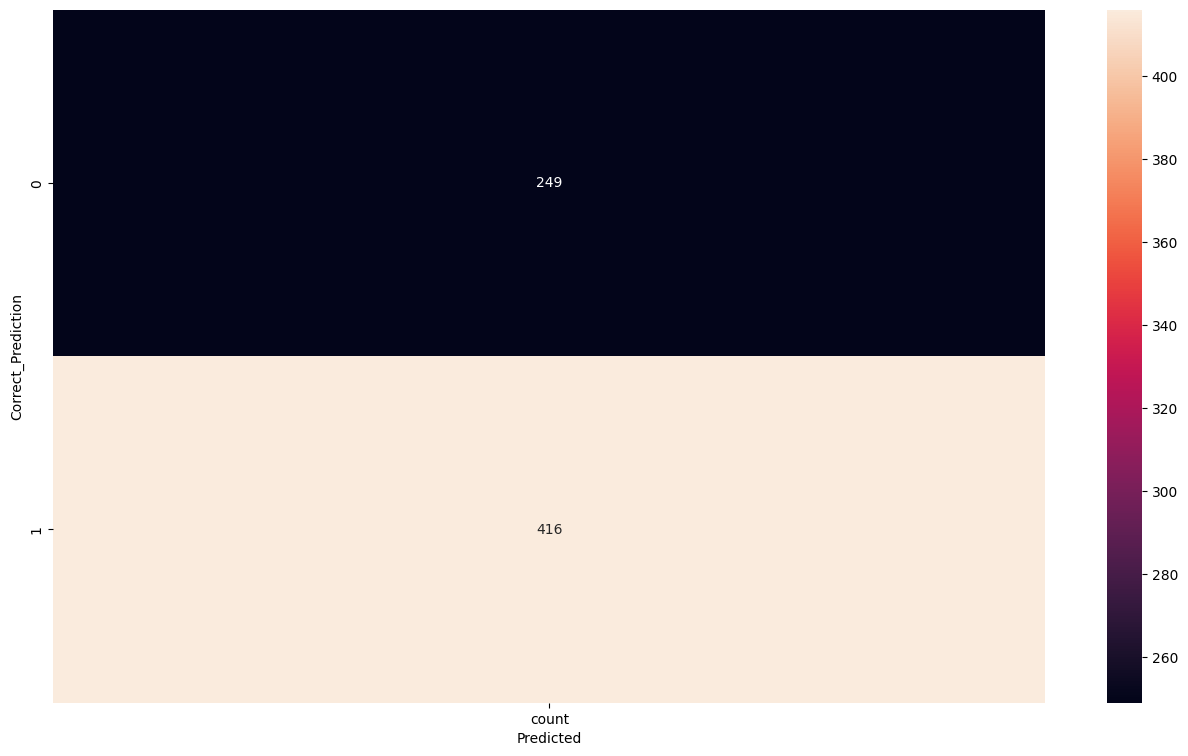

In [ ]:
# Create contingency table
ctab = pd.crosstab(index=res_df['Correct_Prediction'], colnames=['Predicted'], columns='count')

# Plot heatmap
sns.heatmap(ctab, annot=True, fmt='d')

In [ ]:
print(len(test_pred))

In [ ]:
def plot_predictions(res_df):

    res_df['Predicted_PlayerName'] = res_df['Predicted_PlayerName'].astype('category')
    res_df['True_PlayerName'] = res_df['True_PlayerName'].astype('category')
    res_df['Predicted_PlayerName'] = res_df['Predicted_PlayerName'].cat.codes
    res_df['True_PlayerName'] = res_df['True_PlayerName'].cat.codes

    plt.figure(figsize=(8,6))
    sns.kdeplot(data=res_df, x=f'True_PlayerName', label='True Values', fill=True)
    sns.kdeplot(data=res_df, x=f'Predicted_PlayerName', label='ML Predictions', fill=True)
    plt.xlabel('Player Predictions')
    plt.ylabel('Density')
    plt.title('Distribution of ML Predictions and True Values')
    plt.legend()
    plt.show()

plot_predictions(res_df)

# Match Prediction from Team Stats

<h2>Pre-processing Data</h2>

In [34]:
%%capture
def team_df(df, ACS, Kills, Assists, Deaths, players):
    df_list = []

    for name in players:
        mask = (df['PlayerName'] == name)
        roster = df[mask]
        roster = roster[['PlayerName', ACS, Kills, Assists, Deaths]]  # take corresponding player ACS, Kills, Assists, Deaths
        roster.rename(columns={ACS: f'{name}_{ACS}', Kills: f'{name}_{Kills}', Assists: f'{name}_{Assists}', Deaths: f'{name}_{Deaths}'}, inplace=True)
        df_list.append(roster)
    team = pd.DataFrame()
    for i in range(len(df_list)):
        if i == 0:
            team = df_list[i]

        else:

            team = team.merge(df_list[i], how='outer')

    team = team.fillna(0)
    team = pd.get_dummies(team)

    team[ACS] = 0
    team[Kills] = 0
    team[Assists] = 0
    team[Deaths]= 0

    for name in players:

        team[ACS] += team[f'{name}_{ACS}']
        team[Kills] += team[f'{name}_{Kills}']
        team[Assists] += team[f'{name}_{Assists}']
        team[Deaths] += team[f'{name}_{Deaths}']

    return team



In [35]:
team = team_df(merge_df, ACS='ACS', Kills='Kills', Assists='Assists', Deaths='Deaths', players=['bdog', 's0m', "TenZ", 'Reduxx', 'ChurmZ'])

print(team.columns)
team.head()

Index(['bdog_ACS', 'bdog_Kills', 'bdog_Assists', 'bdog_Deaths', 's0m_ACS',
       's0m_Kills', 's0m_Assists', 's0m_Deaths', 'TenZ_ACS', 'TenZ_Kills',
       'TenZ_Assists', 'TenZ_Deaths', 'Reduxx_ACS', 'Reduxx_Kills',
       'Reduxx_Assists', 'Reduxx_Deaths', 'ChurmZ_ACS', 'ChurmZ_Kills',
       'ChurmZ_Assists', 'ChurmZ_Deaths', 'PlayerName_ChurmZ',
       'PlayerName_Reduxx', 'PlayerName_TenZ', 'PlayerName_bdog', 'ACS',
       'Kills', 'Assists', 'Deaths'],
      dtype='object')


,bdog_ACS,bdog_Kills,bdog_Assists,bdog_Deaths,s0m_ACS,s0m_Kills,s0m_Assists,s0m_Deaths,TenZ_ACS,TenZ_Kills,...,ChurmZ_Assists,ChurmZ_Deaths,PlayerName_ChurmZ,PlayerName_Reduxx,PlayerName_TenZ,PlayerName_bdog,ACS,Kills,Assists,Deaths
0,251.0,12.0,7.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0,0,1,251.0,12.0,7.0,10.0
1,246.0,17.0,3.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0,0,1,246.0,17.0,3.0,16.0
2,218.0,14.0,15.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0,0,1,218.0,14.0,15.0,8.0
3,225.0,17.0,3.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0,0,1,225.0,17.0,3.0,13.0
4,198.0,14.0,5.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0,0,1,198.0,14.0,5.0,14.0


In [36]:
team.shape

(71, 28)

In [ ]:
X = player_data.drop(['PlayerName','ACS'], axis=1)
y = player_data['ACS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#print(X_train)
#print(X_test)
X_test.head()

,ADR,Econ,Kills,Deaths,Assists,Agent_astra,Agent_breach,Agent_brimstone,Agent_chamber,Agent_cypher,...,TeamAbbreviation_XSET,TeamAbbreviation_YFP,TeamAbbreviation_ZMM.B,TeamAbbreviation_Zeni,TeamAbbreviation_cism,TeamAbbreviation_ex-FB,TeamAbbreviation_ex-L,TeamAbbreviation_ex-S,TeamAbbreviation_same,TeamAbbreviation_waff
2994,0.472527,0.260638,0.486486,0.586207,0.045455,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
440,0.937729,0.845745,0.567568,0.206897,0.181818,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
960,0.501832,0.271277,0.432432,0.551724,0.136364,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1235,0.351648,0.228723,0.432432,0.413793,0.318182,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
53,0.424908,0.250000,0.351351,0.517241,0.181818,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
def team_stat_predict(df, ACS, Kills, Assists, Deaths):

    #team = team_df(df, ACS, Kills, Assists, Deaths, players)
    model = DecisionTreeRegressor()

    # X = team.drop([f'{ACS}',f'{}'], axis=1)
    # y = team[f'{ACS}']

    # X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.8, test_size=0.2, random_state=42)

    model.fit(X_train, y_train)
    test_pred = model.predict(X_test)


    accuracy = model.score(X_test, y_test)



    # print("The Training accuracy of the model is {:.2f}".format(model.score(X_train, y_train)))
    # print("The Testing accuracy of the model is {:.2f}".format(model.score(X_test, y_test)))

    res_df = X_test


    res_df[f'ML_{ACS}'] = test_pred
    res_df[f'True_{ACS}'] = y_test
    RMS = mean_squared_error(y_test, test_pred)
    RAE= mean_absolute_error(y_test, test_pred)
    R2 = r2_score(y_test, test_pred)
    average = np.average(test_pred)

    return average, accuracy, res_df, RMS, RAE, R2

In [ ]:
# players = ['Reduxx', 'TenZ', 'MaKo', 'Shao', 'Bdog']
#players = ['supA', 's0m', "leaf", 'runi', 'ChurmZ']
ACS = 'ACS'
Kills = 'Kills'
Assists = 'Assists'
Deaths = 'Deaths'


average, accuracy, res, RMS_e, RAE_e, R2_e = team_stat_predict(merge_df, ACS, Kills, Assists, Deaths)


print('Accuracy: ', accuracy)
print('Average stats: ', average)
print('MSE: ', RMS_e)
print('MAE: ', RAE_e)
print('R2: ', R2_e)



res.head()

Accuracy:  0.917103335213903
Average stats:  0.3558121244533929
MSE:  0.0015349687044768307
MAE:  0.030232484978135715
R2:  0.917103335213903


,ADR,Econ,Kills,Deaths,Assists,Agent_astra,Agent_breach,Agent_brimstone,Agent_chamber,Agent_cypher,...,TeamAbbreviation_ZMM.B,TeamAbbreviation_Zeni,TeamAbbreviation_cism,TeamAbbreviation_ex-FB,TeamAbbreviation_ex-L,TeamAbbreviation_ex-S,TeamAbbreviation_same,TeamAbbreviation_waff,ML_ACS,True_ACS
2994,0.472527,0.260638,0.486486,0.586207,0.045455,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.380753,0.437238
440,0.937729,0.845745,0.567568,0.206897,0.181818,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.872385,0.851464
960,0.501832,0.271277,0.432432,0.551724,0.136364,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.443515,0.476987
1235,0.351648,0.228723,0.432432,0.413793,0.318182,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0.357741,0.301255
53,0.424908,0.250000,0.351351,0.517241,0.181818,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.366109,0.355649


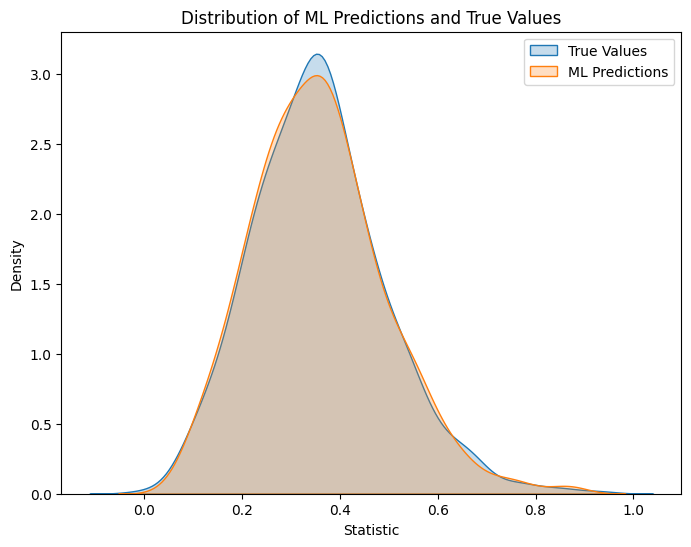

In [ ]:
# def plot_predictions(res_df, ACS, Kills, Assists, Deaths):
def plot_predictions(res_df, ACS):
    plt.figure(figsize=(8, 6))




    sns.kdeplot(data=res_df, x=f'True_{ACS}', label='True Values', fill=True)
    sns.kdeplot(data=res_df, x=f'ML_{ACS}', label='ML Predictions', fill=True)




    # sns.kdeplot(data=res_df, x=f'True_{Kills}', label='True Values', fill=True)
    # sns.kdeplot(data=res_df, x=f'ML_{Kills}', label='ML Predictions', fill=True)



    # sns.kdeplot(data=res_df, x=f'True_{Assists}', label='True Values', fill=True)
    # sns.kdeplot(data=res_df, x=f'ML_{Assists}', label='ML Predictions', fill=True)



    # sns.kdeplot(data=res_df, x=f'True_{Deaths}', label='True Values', fill=True)
    # sns.kdeplot(data=res_df, x=f'ML_{Deaths}', label='ML Predictions', fill=True)



    plt.xlabel('Statistic')
    plt.ylabel('Density')
    plt.title('Distribution of ML Predictions and True Values')
    plt.legend()
    plt.show()

# plot_predictions(res, ACS, Kills, Assists, Deaths)
plot_predictions(res, ACS)